# Binary classification using gene expression

This is an example of how to use sparse logistic regression to classify samples based on gene expression.

The data is form the allend mouse brain atlas, which measured the expression of 3041 genes in 23996 voxels of the mouse brain, whcih were also annotated by a human expert with the brain region the voxel was taken from.

We'll look at a subset of the data: all the voxels that were annotated as originating form either the striatum or the cerebellum, and try to predict the region of origin y from the gene expression of X, in a binary classificatino task.

## Required packages

In [1]:
if (!require(glmnet, quietly=TRUE)) {install.packages('glmnet', repos='http://cran.us.r-project.org')}
if (!require(ggplot2, quietly=TRUE)) {install.packages('ggplot2', repos='http://cran.us.r-project.org')}
if (!require(tidyr, quietly=TRUE)) {install.packages('tidyr', repos='http://cran.us.r-project.org')}

Loaded glmnet 2.0-5


Attaching package: ‘tidyr’

The following object is masked from ‘package:Matrix’:

    expand



## Load Data

* big12vxg_vsn = 3041 genes for 23996 voxels of mouse brain, normalized with vsn
* big12factors = 23996 voxels annotated with of coarse neuroanatomical region
* genesAllen = 3041 allen gene names

In [2]:
if (!exists("big12vxg_vsn")) {
    load("/users/rdonovan/shared_data/allen_brain_big12annotation_vsn.Rdata")
}

## Try to predict if voxel is from cerebellum or striatum

### subset out cerebellum or striatum voxels

In [3]:
data_inds <- (big12factors == 'Cerebellum') | (big12factors == 'Striatum')
X <- big12vxg_vsn[data_inds,]
y <- factor(big12factors[data_inds])
N_samples <- length(y)

print(dim(X))
print(N_samples)
head(colnames(X))

[1] 5056 3041
[1] 5056


[1] "Acadl"  "Acadvl" "Accn1"  "Ace"    "Ache"   "Chrna1"

### split data into train/test and hold-out sets
* choose model parametres via cross-validation on test/train subset of 75% of data
* evaluate final model on 25% holdout data

In [4]:
p = 0.75
test_train_inds <- sample(1:N_samples, N_samples*p, replace = FALSE)

X_test_train <- X[test_train_inds,]
y_test_train <- y[test_train_inds]
X_holdout <- X[-test_train_inds,]
y_holdout <- y[-test_train_inds]

### train cross-validated model to check optimal sparsity

* We're using [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) as our classifier.
* an alpha parameter of 0.95 is a mix of some [ridge](https://en.wikipedia.org/wiki/Tikhonov_regularization) and mostly [lasso](https://en.wikipedia.org/wiki/Lasso_(statistics) regularization, to promote both sparsity and moderate coefficient values.
* alter the alpha parameter (between 0 and 1) to get more or less sparse models.

In [5]:
fit.cv <- cv.glmnet(X_test_train, y_test_train, alpha = 0.95, family='binomial', type.measure = "class")

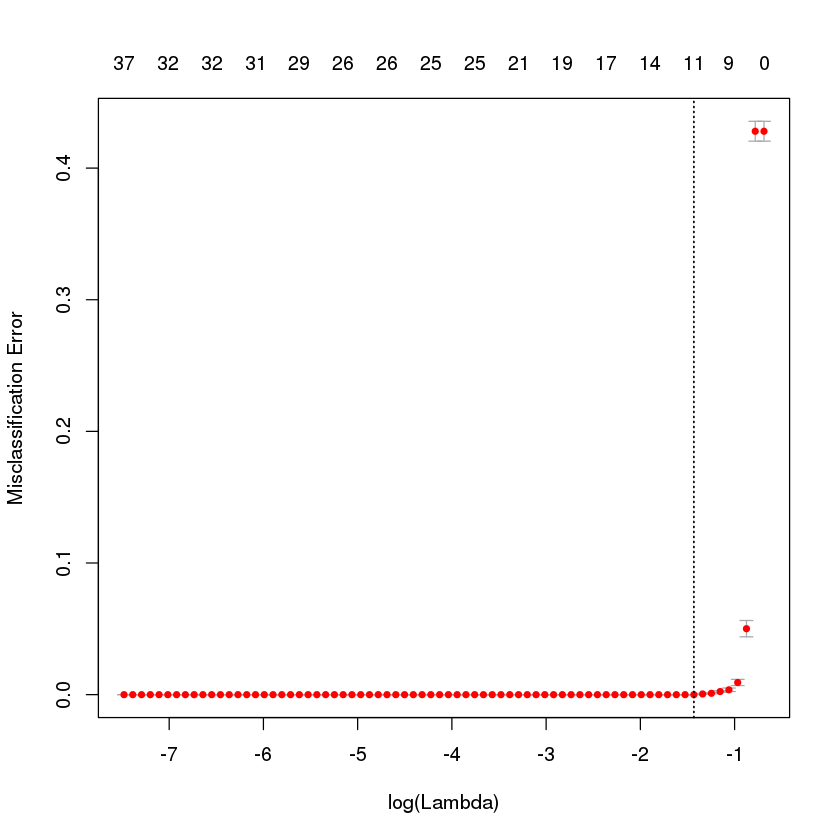

In [6]:
plot(fit.cv)

### train final model using parameters from CV

In [7]:
fit <- glmnet(X_test_train, y_test_train, alpha = 0.95, family='binomial')

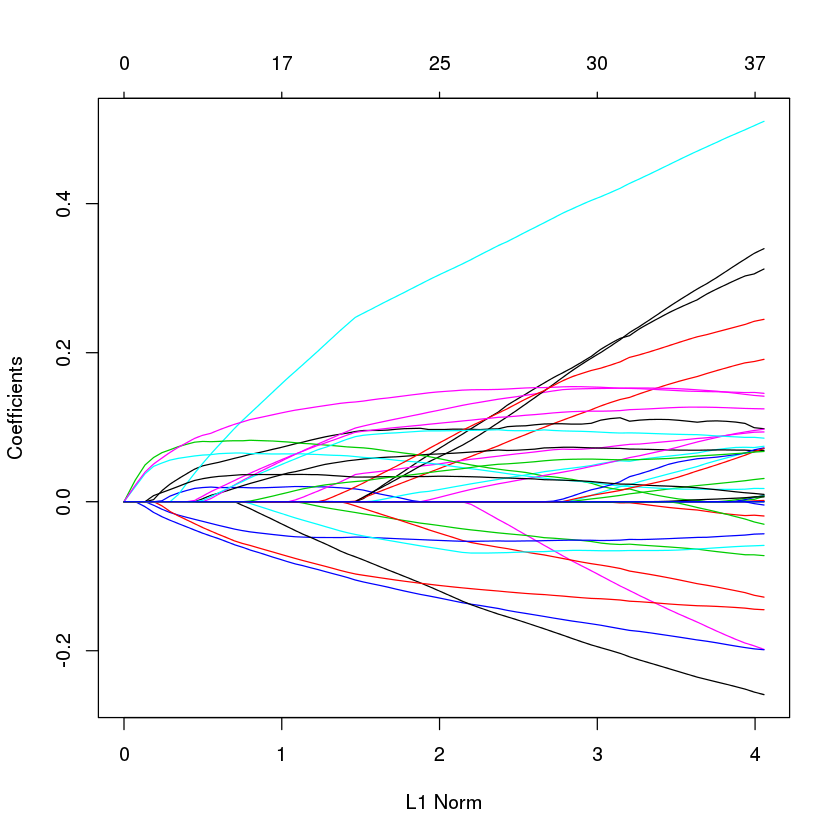

In [8]:
plot(fit)

### check preditions using best sparsity parameter

In [9]:
best_lambda_index <- match(fit.cv$lambda.min, fit.cv$lambda)
preds <- predict(fit, X_holdout, type="class")
fraction_correct <- mean(preds[,best_lambda_index] == y_holdout)
fraction_correct

[1] 1

### nonzero beta coefficients are DEGs

In [10]:
best_betas <- fit$beta[,best_lambda_index]
degs <- best_betas[best_betas  != 0.0]

### make a tidy dataframe for plotting

In [11]:
deg_df <- cbind(Region=y,data.frame(X[,names(degs)]))
deg_df_tidy <- gather(deg_df, 'Gene', 'Expression', -Region)

### look at differential gene expression

#### create ggplot object with styling

In [12]:
p <- ggplot(deg_df_tidy) + 
    theme_minimal() + 
    theme(legend.position = "bottom")

#### plot gnxp density for the two different regions

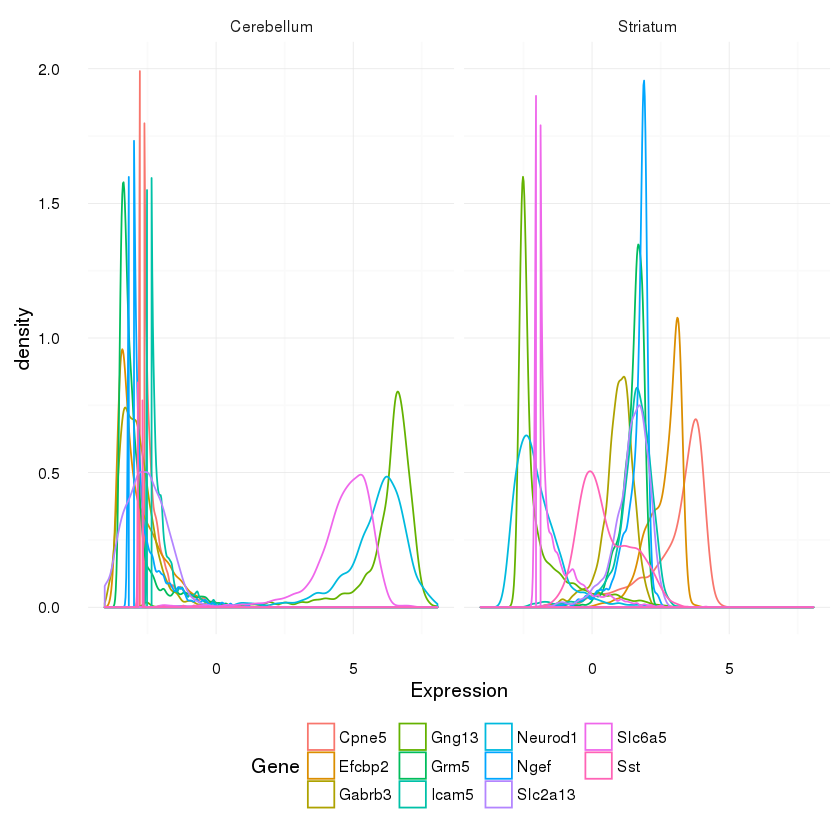

In [13]:
p2 <- p + 
    geom_density(aes(Expression, colour = Gene)) + 
    facet_wrap(~ Region) + ylim(0,2)
p2